In [1]:
%load_ext autoreload
%autoreload 2
import torch
import utils as u
# from utils import NormalMixture1D
# from main import InferenceNetworkPQ_NormalMixture
import main as m
from matplotlib import pyplot as plt
import seaborn as sns

True


/home/aldo/miniconda3/envs/intphys-rl/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

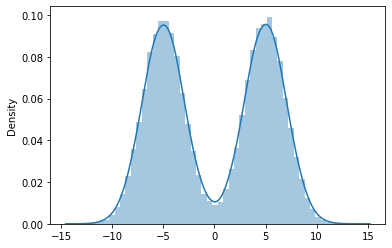

In [2]:
gen_model = u.NormalMixture1D([0.5,0.5], means=[-5, 5], stds=[2,2])
sns.distplot(gen_model.sample(100000))

In [3]:
def get_traces(gen_model, num_traces, obs_std):
    x = gen_model.sample(num_traces)
    obs = torch.distributions.Normal(loc=x,scale=obs_std).sample((1,)).squeeze()
    return x, obs

/home/aldo/miniconda3/envs/intphys-rl/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/aldo/miniconda3/envs/intphys-rl/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

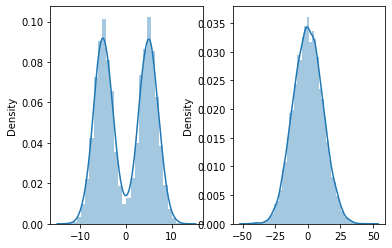

In [23]:
x, obs = get_traces(gen_model, 10000, 10.0)
fig, axes = plt.subplots(1,2)
sns.distplot(x,ax=axes[0])
sns.distplot(obs, ax=axes[1])

In [5]:
def amortize_inference(inference_network, gen_traces_fn, optimizer, num_iterations):
    loss_history = []
    for i in range(num_iterations):
        x, obs = gen_traces_fn()
        loss = inference_network(x, obs)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_history.append(loss.item())

    return loss_history

In [20]:
gen_traces_fn = lambda: get_traces(gen_model, 1000, 10.0)
inference_network = m.InferenceNetworkPQ_NormalMixture(2,1,2,200)
optimizer = torch.optim.Adam(params=inference_network.parameters())


losses = amortize_inference(inference_network, gen_traces_fn, optimizer, 200)


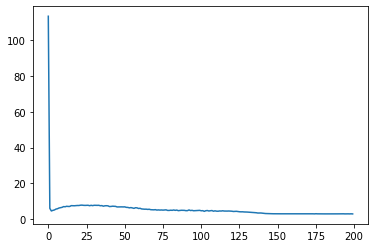

In [21]:
plt.plot(losses)

/home/aldo/miniconda3/envs/intphys-rl/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

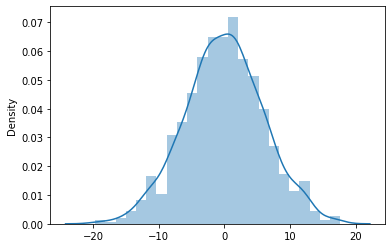

In [31]:
dist = inference_network.get_q_x_given_obs(torch.tensor([-0.0]*2))

sns.distplot(u.NormalMixture1D(mixture_probs=dist.mixture_probs[0], 
                means=dist.normals.loc[0], 
                stds=dist.normals.scale[0]).sample(1000))

